First, import needed modules

In [289]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
from shapely import wkt
from shapely.ops import unary_union

Initalize variables

In [290]:
shapely.speedups.enable()
path = os.getcwd()
print(path)

/Users/jan/Dropbox/UP_EPQM/2222/MA/powerlinemonsters


Load shapefile with municipalities

In [291]:
municipalities = gpd.read_file(f'{path}/data/geodata/VG250_GEM.shp')
municipalities.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Drop polygons which represent waterbodies

<AxesSubplot:>

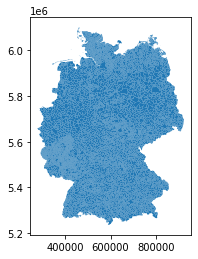

In [292]:
municipalities = municipalities[municipalities['GF'] == 4] 
#municipalities = municipalities[municipalities["BEZ"] != 'Gemeindefreies Gebiet']
municipalities.plot()

Inspect gemeindefreie Gebiete (unincorporated areas, mostly forests)

In [293]:
mun_unincorporated = municipalities[municipalities['BEZ'] == 'Gemeindefreies Gebiet']
mun_unincorporated.shape
# There are 220 unicorporated areas, only two are inhabitated

(220, 25)

Create geopandas df with uninhabited unincorporated areas

In [294]:
mun_unincorporated = municipalities[municipalities['BEZ'] == 'Gemeindefreies Gebiet']
mun_unincorporated = mun_unincorporated[mun_unincorporated['EWZ'] == 0]
mun_unincorporated.shape
mun_unincorporated.to_file(f'{path}/data/geodata/unincorporated.shp')

The data use the European Terrestrial Reference System 1989 as coordinate reference system (CRS), units are metres

In [295]:
municipalities.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load shapefiles with power lines

In [296]:
pl_05 = gpd.read_file(f'{path}/data/geodata/powerlines_05.shp')
pl_09 = gpd.read_file(f'{path}/data/geodata/powerlines_09.shp')
pl_13 = gpd.read_file(f'{path}/data/geodata/powerlines_13.shp')

Load shapefiles with start and endpoints

In [297]:
start_05 = gpd.read_file(f'{path}/data/geodata/startpoints_05.shp')
end_05 = gpd.read_file(f'{path}/data/geodata/endpoints_05.shp')
start_09 = gpd.read_file(f'{path}/data/geodata/startpoints_09.shp')
end_09 = gpd.read_file(f'{path}/data/geodata/endpoints_09.shp')
start_13 = gpd.read_file(f'{path}/data/geodata/startpoints_13.shp')
end_13 = gpd.read_file(f'{path}/data/geodata/endpoints_13.shp')

Concatenate start and endpoints dfs

In [298]:
# First rename columns to allow concatenation
starts = [start_05, start_09, start_13]
for df in starts: 
    df.rename(columns = {'Start': 'Name', 'Int_start': 'Int'}, inplace = True)
ends = [end_05, end_09, end_13]
for df in ends: 
    df.rename(columns = {'End': 'Name', 'Int_end': 'Int'}, inplace = True)

In [299]:
points_05 = pd.concat([start_05, end_05])
points_09 = pd.concat([start_09, end_09])
points_13 = pd.concat([start_13, end_13])

Filter out Retrofitting projects, short lines and intermediate start- and endpoints

In [300]:
# For 2005 there are no retrofit and short projects
points_05 = points_05[points_05['Int'] != 1]
points_05.shape

(22, 7)

In [301]:
# For 2009 there are no retrofit projects
pl_09 = pl_09[pl_09['Short'] != 1]
points_09 = points_09[points_09['Int'] != 1]
points_09 = points_09[points_09['Short'] != 1]

In [302]:
pl_13 = pl_13[pl_13['New'] == 1]
pl_13 = pl_13[pl_13['Short'] != 1]
points_13 = points_13[points_13['New'] == 1]
points_13 = points_13[points_13['Short'] != 1]
points_13 = points_13[points_13['Int'] != 1]

Export new powerline shapefile

In [303]:
pl_09.to_file(f'{path}/data/geodata/new_powerlines_09.shp')
pl_13.to_file(f'{path}/data/geodata/new_powerlines_13.shp')

Create dataset with all powerlines, add description, year and colors

In [304]:
dfs = [pl_05, pl_09, pl_13]
years = ['2005', '2009', '2013']
descriptions = ['DENA 2005', 'EnLAG 2009', 'BBPlG 2013']
colors = ['#1ED4CE', '#B8FDE7', '#1B5EB6']
for df, year, description, color in zip(dfs, years, descriptions, colors):
    df['year'] = year
    df['description'] = description
    df['color'] = color
all_powerlines = pd.concat(dfs)
all_powerlines.to_file(f'{path}/data/geodata/all_powerlines.shp')

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_8556/8489537.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_powerlines.to_file(f'{path}/data/geodata/all_powerlines.shp')


Create buffers around the straight lines to create treatment indicator for different corridor widths

In [305]:
dfs = [pl_05, pl_09, pl_13]
for df in dfs:
    for buffer in (15, 30, 50):
        try:
            df.insert(loc=len(df.columns), column=f'geometry_{buffer}', value=0)
        except Exception:
            pass
        df[f'geometry_{buffer}'] = df['geometry'].buffer(buffer*1000)
    df.rename(columns = {'geometry':'geometry_0'}, inplace = True)

Generate treatment indicators for all buffer sizes

In [306]:
for buffer in (0, 15, 30, 50):
    try:
        municipalities.insert(loc=len(municipalities.columns), column=f'treatment_{buffer}_05', value=0)
        municipalities.insert(loc=len(municipalities.columns), column=f'treatment_{buffer}_09', value=0)
        municipalities.insert(loc=len(municipalities.columns), column=f'treatment_{buffer}_13', value=0)
    except Exception:
        pass
    for i in range(len(municipalities)):
        # this sets treated_x = True, if powerline intersects a municipality
        municipalities.loc[municipalities.index[i], f'treatment_{buffer}_05'] = any(pl_05[f'geometry_{buffer}'].intersects(municipalities['geometry'].values[i]))
        municipalities.loc[municipalities.index[i], f'treatment_{buffer}_09'] = any(pl_09[f'geometry_{buffer}'].intersects(municipalities['geometry'].values[i]))
        municipalities.loc[municipalities.index[i], f'treatment_{buffer}_13'] = any(pl_13[f'geometry_{buffer}'].intersects(municipalities['geometry'].values[i]))
        # this sets the treatment year variable
        municipalities['treated_2005'] = np.where(municipalities[f'treatment_{buffer}_05'] == True, 1, 0)
        municipalities['treated_2009'] = np.where(municipalities[f'treatment_{buffer}_09'] == True, 1, 0)
        municipalities['treated_2013'] = np.where(municipalities[f'treatment_{buffer}_13'] == True, 1, 0)

Create treatment year variable

In [307]:
municipalities['treatment_year'] = np.where(municipalities['treated_2013'] == 1, 2014, 0)
municipalities['treatment_year'] = np.where(municipalities['treated_2009'] == 1, 2010, municipalities['treatment_year'])
municipalities['treatment_year'] = np.where(municipalities['treated_2005'] == 1, 2005, municipalities['treatment_year'])
municipalities['treatment_year'].value_counts()

2005    4170
0       3188
2010    2187
2014    1834
Name: treatment_year, dtype: int64

Set treatment = False if municipality is a start- or endpoint

In [308]:
# All endpoints ever
points = pd.concat([points_05, points_09, points_13])
for buffer in (0, 15, 30, 50):
    for i in range(len(municipalities)):
        if any(points['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer}_05'] = False
        if any(points['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer}_09'] = False
        if any(points['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer}_13'] = False

Reset the treatment year variable to check success

In [309]:
for buffer in (0, 15, 30, 50):
    municipalities['treated_2005'] = np.where(municipalities[f'treatment_{buffer}_05'] == True, 1, 0)
    municipalities['treated_2009'] = np.where(municipalities[f'treatment_{buffer}_09'] == True, 1, 0)
    municipalities['treated_2013'] = np.where(municipalities[f'treatment_{buffer}_13'] == True, 1, 0)
municipalities['treatment_year'] = np.where(municipalities['treated_2013'] == 1, 2014, 0)
municipalities['treatment_year'] = np.where(municipalities['treated_2009'] == 1, 2010, municipalities['treatment_year'])
municipalities['treatment_year'] = np.where(municipalities['treated_2005'] == 1, 2005, municipalities['treatment_year'])
municipalities['treatment_year'].value_counts()

2005    4131
0       3243
2010    2175
2014    1830
Name: treatment_year, dtype: int64

Create single treatment (type) indicators for each year --> This also 'unnests' the treatment groups

In [310]:
years = ['05', '09', '13']
for year in years:
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_50_{year}'] == True, 50, np.nan)
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_30_{year}'] == True, 30, municipalities[f'treatment_{year}'])
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_15_{year}'] == True, 15, municipalities[f'treatment_{year}'])
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_0_{year}'] == True, 0, municipalities[f'treatment_{year}'])
    print(municipalities[f'treatment_{year}'].value_counts())

50.0    1479
30.0    1284
15.0    1103
0.0      265
Name: treatment_05, dtype: int64
50.0    1701
30.0    1524
15.0    1498
0.0      263
Name: treatment_09, dtype: int64
50.0    2165
15.0    2095
30.0    1911
0.0      491
Name: treatment_13, dtype: int64


Create treatment (in year) indicator for all buffer sizes

In [311]:
for buffer in (0, 15, 30, 50):
    municipalities[f'treatment_{buffer}'] = np.where(municipalities[f'treatment_{buffer}_13'] == True, 2014, 0)
    municipalities[f'treatment_{buffer}'] = np.where(municipalities[f'treatment_{buffer}_09'] == True, 2010, municipalities[f'treatment_{buffer}'])
    municipalities[f'treatment_{buffer}'] = np.where(municipalities[f'treatment_{buffer}_05'] == True, 2005, municipalities[f'treatment_{buffer}'])
    print(municipalities[f'treatment_{buffer}'].value_counts())

0       10568
2014      375
2005      265
2010      171
Name: treatment_0, dtype: int64
0       7279
2014    1587
2005    1368
2010    1145
Name: treatment_15, dtype: int64
0       5028
2005    2652
2014    1907
2010    1792
Name: treatment_30, dtype: int64
2005    4131
0       3243
2010    2175
2014    1830
Name: treatment_50, dtype: int64


Generate indicator for ever treatment level / never treated status of a municipality

In [312]:
municipalities['ever_treated'] = municipalities[['treatment_05', 'treatment_09', 'treatment_13']].min(axis=1)
municipalities['ever_treated_2010'] = municipalities[['treatment_05', 'treatment_09']].min(axis=1)
municipalities['ever_treated'] = municipalities['ever_treated'].astype('Int64').astype(str)
municipalities['ever_treated_2010'] = municipalities['ever_treated_2010'].astype('Int64').astype(str)
treatments = {'<NA>': 'None', '0': 'Direct Line', '15': 'Within 15km', '30': 'Within 30km', '50': 'Within 50km'}
for value, description in treatments.items():
    municipalities['ever_treated'] = np.where(municipalities['ever_treated'] == value, description, municipalities['ever_treated'])
    municipalities['ever_treated_2010'] = np.where(municipalities['ever_treated_2010'] == value, description, municipalities['ever_treated_2010'])
municipalities['ever_treated'].value_counts()

Within 15km    3289
None           3243
Within 30km    2251
Within 50km    1785
Direct Line     811
Name: ever_treated, dtype: int64

In [313]:
municipalities['ever_treated_2010'].value_counts()

None           5073
Within 15km    2077
Within 30km    1931
Within 50km    1862
Direct Line     436
Name: ever_treated_2010, dtype: int64

In [314]:
municipalities['never_treated'] = np.where(municipalities['ever_treated'] == 'None', 1, 0)
municipalities['never_treated'].value_counts()

0    8136
1    3243
Name: never_treated, dtype: int64

Reset treatment_{year} to string values

In [315]:
years = ['05', '09', '13']
for year in years:
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_50_{year}'] == True, 'Within 50km', 'None')
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_30_{year}'] == True, 'Within 30km', municipalities[f'treatment_{year}'])
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_15_{year}'] == True, 'Within 15km', municipalities[f'treatment_{year}'])
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_0_{year}'] == True, 'Direct Line', municipalities[f'treatment_{year}'])
    print(municipalities[f'treatment_{year}'].value_counts())

None           7248
Within 50km    1479
Within 30km    1284
Within 15km    1103
Direct Line     265
Name: treatment_05, dtype: int64
None           6393
Within 50km    1701
Within 30km    1524
Within 15km    1498
Direct Line     263
Name: treatment_09, dtype: int64
None           4717
Within 50km    2165
Within 15km    2095
Within 30km    1911
Direct Line     491
Name: treatment_13, dtype: int64


Add color columns

In [316]:
colors = {'None': '#74d8c9', 'Direct Line': '#A1084F', 'Within 15km': '#042A5B', 'Within 30km': '#247385', 'Within 50km': '#38C7B2'}
years = ['05', '09', '13']
for desc, color in colors.items():
    municipalities['et14_color'] = np.where(municipalities['ever_treated'] == desc, color, municipalities['et14_color'])
    municipalities['et10_color'] = np.where(municipalities['ever_treated_2010'] == desc, color, municipalities['et10_color'])
    municipalities['05_color'] = np.where(municipalities['treatment_05'] == desc, color, municipalities['05_color'])
    municipalities['09_color'] = np.where(municipalities['treatment_09'] == desc, color, municipalities['09_color'])
    municipalities['13_color'] = np.where(municipalities['treatment_13'] == desc, color, municipalities['13_color'])

KeyError: 'et14_color'

In [ ]:
municipalities['05_color'].value_counts()

#74d8c9    7248
#38C7B2    1479
#247385    1284
#042A5B    1103
#A1084F     265
Name: 05_color, dtype: int64

Export municipality shapefile

In [ ]:
columns = ['AGS', 'GEN', 'SN_L', 'geometry', 'treatment_05', 'treatment_09', 'treatment_13', 'ever_treated', 'ever_treated_2010', 'never_treated']
#columns = columns + ['treated_2005', 'treated_2009', 'treated_2013', 'treatment_30_05','treatment_60_05','treatment_100_05', 'treatment_30_09','treatment_60_09','treatment_100_09', 'treatment_30_13','treatment_60_13','treatment_100_13']
columns = columns + ['05_color', '09_color', '13_color', 'et10_color', 'et14_color']
mun_out = municipalities.reindex(columns=columns)
mun_out.rename(columns = {'treatment_05':'t2005', 'treatment_09':'t2009','treatment_13':'t2013', 'ever_treated_2010':'et2010', 'ever_treated':'et2014'}, inplace = True)
mun_out.to_file(f'{path}/data/geodata/municipalities.shp')

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_8556/3819709125.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mun_out.to_file(f'{path}/data/geodata/municipalities.shp')


Export treatment dataset from municipalities dataframe

In [ ]:
treatment = pd.DataFrame(municipalities)
columns = ['AGS', 'GEN', 'treatment_05', 'treatment_09', 'treatment_13', 'treatment_0', 'treatment_15', 'treatment_30', 'treatment_50', 'ever_treated', 'ever_treated_2010', 'never_treated']
#columns = columns + ['treated_2005', 'treated_2009', 'treated_2013', 'treatment_30_05','treatment_60_05','treatment_100_05', 'treatment_30_09','treatment_60_09','treatment_100_09', 'treatment_30_13','treatment_60_13','treatment_100_13']
treatment = treatment.reindex(columns=columns)
treatment = treatment.set_index('AGS')
treatment = treatment.replace({True:1, False:0})
treatment.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
treatment.head()

,GEN,treatment_05,treatment_09,treatment_13,treatment_0,treatment_15,treatment_30,treatment_50,ever_treated,ever_treated_2010,never_treated
AGS,,,,,,,,,,,
08437105,Sigmaringendorf,None,None,None,0,0,0,0,None,None,1
08435010,Daisendorf,None,None,None,0,0,0,0,None,None,1
08426036,Dürnau,None,None,None,0,0,0,0,None,None,1
08436079,Waldburg,None,None,None,0,0,0,0,None,None,1
08436053,Königseggwald,None,None,None,0,0,0,0,None,None,1
